# **Image-to-Image Translation with cGAN**

## **Install Required Libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm


## ***Loading the data and variable declaring***

In [3]:
# for the dataset, we will first declare some global variables
batch_size = 16
epoch_count = 50
noise_dim = 100
n_class = 10
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
img_size = 32

# Load the dataset
(X_train, y_train), (_, _) = cifar10.load_data()

# Normalize the data
X_train = (X_train - 127.5) / 127.5

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## ***Visualizing the data***

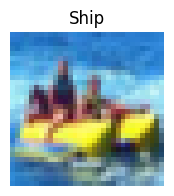

In [4]:
# plotting a random image from the dataset
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()


In [5]:
# Define Loss function for Classification between Real and Fake
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
	real_loss = bce_loss(tf.ones_like(real), real)
	fake_loss = bce_loss(tf.zeros_like(fake), fake)
	total_loss = real_loss + fake_loss
	return total_loss

# Generator Loss
def generator_loss(preds):
	return bce_loss(tf.ones_like(preds), preds)

# Optimiser for both Generator and Dsicriminator
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)


## **Building the Generator Model**

In [6]:
def build_generator():

# label input
	in_label = tf.keras.layers.Input(shape=(1,))

	# create an embedding layer for all the 10 classes in the form of a vector
	# of size 50
	li = tf.keras.layers.Embedding(n_class, 50)(in_label)

	n_nodes = 8 * 8
	li = tf.keras.layers.Dense(n_nodes)(li)
	# reshape the layer
	li = tf.keras.layers.Reshape((8, 8, 1))(li)

	# image generator input
	in_lat = tf.keras.layers.Input(shape=(noise_dim,))

	n_nodes = 128 * 8 * 8
	gen = tf.keras.layers.Dense(n_nodes)(in_lat)
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
	gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

	# merge image gen and label input
	merge = tf.keras.layers.Concatenate()([gen, li])

	gen = tf.keras.layers.Conv2DTranspose(
		128, (4, 4), strides=(2, 2), padding='same')(merge) # 16x16x128
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

	gen = tf.keras.layers.Conv2DTranspose(
		128, (4, 4), strides=(2, 2), padding='same')(gen) # 32x32x128
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

	out_layer = tf.keras.layers.Conv2D(
		3, (8, 8), activation='tanh', padding='same')(gen) # 32x32x3

	model = Model([in_lat, in_label], out_layer)
	return model


g_model = build_generator()
g_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8192)           │        827,392 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 50)          │            500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 8192)           │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 64)          │          3,264 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 8, 8, 128)      │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8, 8, 1)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 129)      │              0 │ reshape_1[0][0],       │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 128)    │        264,320 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 128)    │        262,272 │ leaky_re_lu_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 3)      │         24,579 │ leaky_re_lu_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def build_discriminator():

 # label input
 in_label = tf.keras.layers.Input(shape=(1,))
 #This vector of size 50 will be learnt by the discriminator
 li = tf.keras.layers.Embedding(n_class, 50)(in_label)

 n_nodes = img_size * img_size
 li = tf.keras.layers.Dense(n_nodes)(li)

 li = tf.keras.layers.Reshape((img_size, img_size, 1))(li)


 # image input
 in_image = tf.keras.layers.Input(shape=(img_size, img_size, 3))

 merge = tf.keras.layers.Concatenate()([in_image, li])


 #We will combine input label with input image and supply as inputs to the model.
 fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
 fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

 fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
 fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

 fe = tf.keras.layers.Flatten()(fe)

 fe = tf.keras.layers.Dropout(0.4)(fe)

 out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)

 # define model the model.
 model = Model([in_image, in_label], out_layer)

 return model


d_model = build_discriminator()
d_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 50)          │            500 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 1024)        │         52,224 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 32, 32, 1)      │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 32, 32, 4)      │              0 │ input_layer_5[0][0],   │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │          4,736 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 8, 8, 128)      │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 8192)           │              0 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8192)           │              0 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │          8,193 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 213,237 (832.96 KB)

 Trainable params: 213,237 (832.96 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compiles the train_step function into a callable TensorFlow graph
@tf.function
def train_step(dataset):

	real_images, real_labels = dataset
	# Sample random points in the latent space and concatenate the labels.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
	generated_images = g_model([random_latent_vectors, real_labels])

	# Train the discriminator.
	with tf.GradientTape() as tape:
		pred_fake = d_model([generated_images, real_labels])
		pred_real = d_model([real_images, real_labels])

		d_loss = discriminator_loss(pred_real, pred_fake)

	grads = tape.gradient(d_loss, d_model.trainable_variables)
	# print(grads)
	d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

	#-----------------------------------------------------------------#

	# Sample random points in the latent space.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

	# Train the generator
	with tf.GradientTape() as tape:
		fake_images = g_model([random_latent_vectors, real_labels])
		predictions = d_model([fake_images, real_labels])
		g_loss = generator_loss(predictions)

	grads = tape.gradient(g_loss, g_model.trainable_variables)
	g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))

	return d_loss, g_loss


In [13]:
# Helper function to plot generated images
def show_samples(num_samples, n_class, g_model):
  fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=0.2)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([]) #fixed indentation here
      axes[l,j].xaxis.set_ticks([]) #fixed indentation here

      if j ==0:
        axes[l,j].set_ylabel(tags[l]) #fixed indentation here
  plt.show()

## **Training the model and Visualize the output**

In [ ]:
def train(dataset, epochs=epoch_count):

	for epoch in range(epochs):
		print('Epoch: ', epochs)
		d_loss_list = []
		g_loss_list = []
		q_loss_list = []
		start = time.time()

		itern = 0
		for image_batch in tqdm(dataset):
			d_loss, g_loss = train_step(image_batch)
			d_loss_list.append(d_loss)
			g_loss_list.append(g_loss)
			itern=itern+1

		show_samples(3, n_class, g_model)

		print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
		print (f'Took {time.time()-start} seconds. \n\n')


train(dataset, epochs=epoch_count)


Epoch:  50


  2%|▏         | 67/3125 [01:35<1:00:40,  1.19s/it]